https://sh-tsang.medium.com/review-empirical-evaluation-of-gated-recurrent-neural-networks-on-sequence-modeling-gru-2adb86559257

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

https://www.youtube.com/watch?v=0_PgWWmauHk

In [24]:
import torch
import torch.nn as nn   # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, LossFunctions
import torch.optim as optim     #  For all optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F     #  All functions that dont have any parameters
from torch.utils.data import DataLoader     #  Gives easier datasets managment and creates mini batches
import torchvision.datasets as datasets     #  Has standard datasets we can import in a nice way
import torchvision.transforms as transforms     #  Transformations we can perform on our dataset 
import matplotlib.pyplot as plt

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
#   Hyperparemeters
input_size = 28
sequence_len = 28
num_class = 10
num_layers = 2
hidden_size = 256
learning_rate = 0.001
batch_size = 64
num_epochs = 2

In [27]:
#   Create a RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_class):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, x):
        #   Shape of INPUT:  1. x => (batch_size x sequence_len x input_size)
        #                    2. h0 => (num_layers x batch_size x hidden_size)
        h0 = torch.randn(self.num_layers, x.size(dim = 0), self.hidden_size).to(device = device)
        c0 = torch.randn(self.num_layers, x.size(dim = 0), self.hidden_size).to(device = device)
        #   Shape of OUTPUT:  1. out => (batch_size x sequence_len x hidden_size)
        #                     2. h_n => (num_layers x batch_size x hidden_size)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        #   Feed only last hidden state to fc layer
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [29]:
train_data = datasets.MNIST(root = 'Datasets\\', train = True, transform = transforms.ToTensor(), download = False)
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_data = datasets.MNIST(root = 'Datasets\\', train = False, transform = transforms.ToTensor(), download = False)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [30]:
model = RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, num_class = num_class).to(device)

In [31]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)

In [32]:
loss_cummulative = []
for epoch in range(num_epochs):
    for (data, labels) in train_loader:
        data = data.to(device).squeeze(1)
        labels = labels.to(device)

        Y_pred = model(data)
        loss = loss_func(Y_pred, labels)
        loss_cummulative.append(loss.item())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

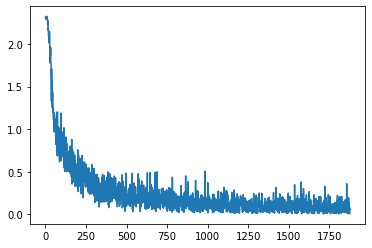

In [33]:
plt.plot(loss_cummulative);

In [34]:
def check_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device).squeeze(1)
            labels = labels.to(device)

            Y_pred = model(data)
            _, max_idx = Y_pred.max(dim = 1)

            num_correct += (max_idx == labels).sum()
            num_samples += Y_pred.shape[0]
        
        print(f"Got {num_correct}/{num_samples} with accuracy {num_correct/num_samples*100:.2f}")

In [35]:
check_acc(test_loader, model)

Got 9763/10000 with accuracy 97.63
